In [62]:

%matplotlib inline
%config InlineBackend.figure_format='retina'

from matplotlib import gridspec #import GridSpec
import matplotlib.pyplot as plt
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

os.system('module load texlive/2022')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size"  : 13
})

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'w'



In [10]:

def rd2tp(ra,dec):
    tht = (-dec+90.0)/180.0*np.pi
    phi = ra/180.0*np.pi
    return tht,phi

def corrs(Xra,Xdec,Xg1,Xg2,Xw, Yra,Ydec,Yg1,Yg2,Yw,xtype):
    '''
    Computes correlation. The scale cuts are different depending on xip vs xim
    '''
    if xtype=='xip':
        thtmin,thtmax = 7,56
    if xtype=='xim': 
        thtmin,thtmax = 28,178    
    
    corr = treecorr.GGCorrelation(min_sep       = thtmin,
                                  max_sep       = thtmax,
                                  nbins         = 9,
                                  bin_slop      = 0.00,
                                  sep_units     = "arcmin",
                                  var_method    = "jackknife")
    
    cat1 = treecorr.Catalog(ra=Xra, dec=Xdec, g1=Xg1, g2=Xg2 ,w=Xw, ra_units="deg", dec_units="deg", npatch=150)
    cat2 = treecorr.Catalog(ra=Yra, dec=Ydec, g1=Yg1, g2=Yg2 ,w=Yw, ra_units="deg", dec_units="deg", patch_centers=cat1.patch_centers)

    corr.process(cat1, cat2)
    if xtype=='xip':
        return np.exp(corr.meanlogr), corr.xip
    if xtype=='xim':
        return np.exp(corr.meanlogr), corr.xim

# Load shear catalog

In [65]:
# These pre-cured catalogs are produced by ingesting the raw catalogs from Gabiela:
# /global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe
# and passing them through TXSourceSelectorHSC & TXShearCalibration 
# and combining them for each redshift bin.


fieldlist = ['GAMA09H','GAMA15H','HECTOMAP', 'VVDS', 'WIDE12H', 'XMM']

for i in range(0,4):
    gra = np.array([])
    gdec= np.array([])
    g1 = np.array([])
    g2 = np.array([])
    gw  = np.array([])
    
    for field in fieldlist:
        with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/binned_shear_catalog_%s.h5"%field,"r") as f:
            gra  = np.concatenate([gra, f['shear/bin_%d/ra'%i][:] ])
            gdec = np.concatenate([gdec,f['shear/bin_%d/dec'%i][:] ])
            g1   = np.concatenate([g1  ,f['shear/bin_%d/g1'%i][:] ])
            g2   = np.concatenate([g2  ,f['shear/bin_%d/g2'%i][:] ])
            gw   = np.concatenate([gw  ,f['shear/bin_%d/weight'%i][:] ])
    
    d = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/'
    np.savez(d+'binned_shear_catalog_allfields_zbin%d.npz'%(i+1),ra=gra, dec=gdec, g1=g1, g2=g2, gw=gw)
    
    
    
allgra = np.array([])
allgdec= np.array([])
allg1  = np.array([])
allg2  = np.array([])
allgw  = np.array([])

for i in range(0,4):
    print(i)

    d = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/'
    x = np.load(d+'binned_shear_catalog_allfields_zbin%d.npz'%(i+1))
    allgra  = np.concatenate([allgra, x['ra'] ])
    allgdec = np.concatenate([allgdec,x['dec']])
    allg1   = np.concatenate([allg1  ,x['g1'] ])
    allg2   = np.concatenate([allg2  ,x['g2']])
    allgw   = np.concatenate([allgw  ,x['gw'] ])


0
1
2
3


# Load star catalog

In [12]:
# These are the star Catalogs that were given by Rachel:
# /global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc_stars/
# These have been verified to produce correct Rowe stats in
# https://github.com/LSSTDESC/nulltests_txpipe/blob/main/hscy1/rhostat/hscy1_rowestats.ipynb

import os,sys
import treecorr
import h5py
import numpy as np
from astropy.io import fits

def get_T_e1e2(d,colprefix,idx):
    ixx = d[1].data[colprefix+'_ixx'][idx]
    iyy = d[1].data[colprefix+'_iyy'][idx]
    ixy = d[1].data[colprefix+'_ixy'][idx]
    T   = ixx + iyy
    e1  = (ixx-iyy)/T
    e2  = 2*ixy/T
    return T,e1,e2

fieldlist = ['GAMA09H','GAMA15H','HECTOMAP', 'VVDS', 'WIDE12H', 'XMM']

dd       ={}

for stype in (['u','r']):

    ra  = np.array([])
    dec = np.array([])
    T_meas   = np.array([])
    T_model  = np.array([])
    e1_meas  = np.array([])
    e2_meas  = np.array([])
    e1_model = np.array([])
    e2_model = np.array([])
    idxr     = np.array([])
    idxu     = np.array([])
    
    dd[stype]={}
    print('__________',stype)
    for field in fieldlist:
        d = fits.open('/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc_stars//%s_stars.fits'%field)
        print('__________',field)
        if stype=='u': idx = np.where(d[1].data['icalib_psf_used']==True)[0]
        if stype=='r': idx = np.where(d[1].data['icalib_psf_used']==False)[0]
    
        uT_model, ue1_model, ue2_model = get_T_e1e2(d,'ishape_sdss_psf',idx)
        uT_meas, ue1_meas, ue2_meas    = get_T_e1e2(d,'ishape_sdss',idx);
    
        ra  = np.concatenate([ra ,  d[1].data['ira'][idx] ])
        dec = np.concatenate([dec,  d[1].data['idec'][idx] ])
        T_meas   = np.concatenate([T_meas,uT_meas])
        T_model  = np.concatenate([T_model,uT_model])
        e1_meas  = np.concatenate([e1_meas,ue1_meas])
        e2_meas  = np.concatenate([e2_meas,ue2_meas])
        e1_model = np.concatenate([e1_model,ue1_model])
        e2_model = np.concatenate([e2_model,ue2_model])
     
    dd[stype]['ra']=ra
    dd[stype]['dec']=dec
    dd[stype]['T_meas']=T_meas
    dd[stype]['T_model']=T_model
    dd[stype]['e1_meas']=e1_meas*0.5
    dd[stype]['e2_meas']=-e2_meas*0.5
    dd[stype]['e1_model']=e1_model*0.5
    dd[stype]['e2_model']=-e2_model*0.5

__________ u
__________ GAMA09H
__________ GAMA15H
__________ HECTOMAP
__________ VVDS
__________ WIDE12H
__________ XMM
__________ r
__________ GAMA09H
__________ GAMA15H
__________ HECTOMAP
__________ VVDS
__________ WIDE12H
__________ XMM


# Check that the shear footprint and star footprint overlap


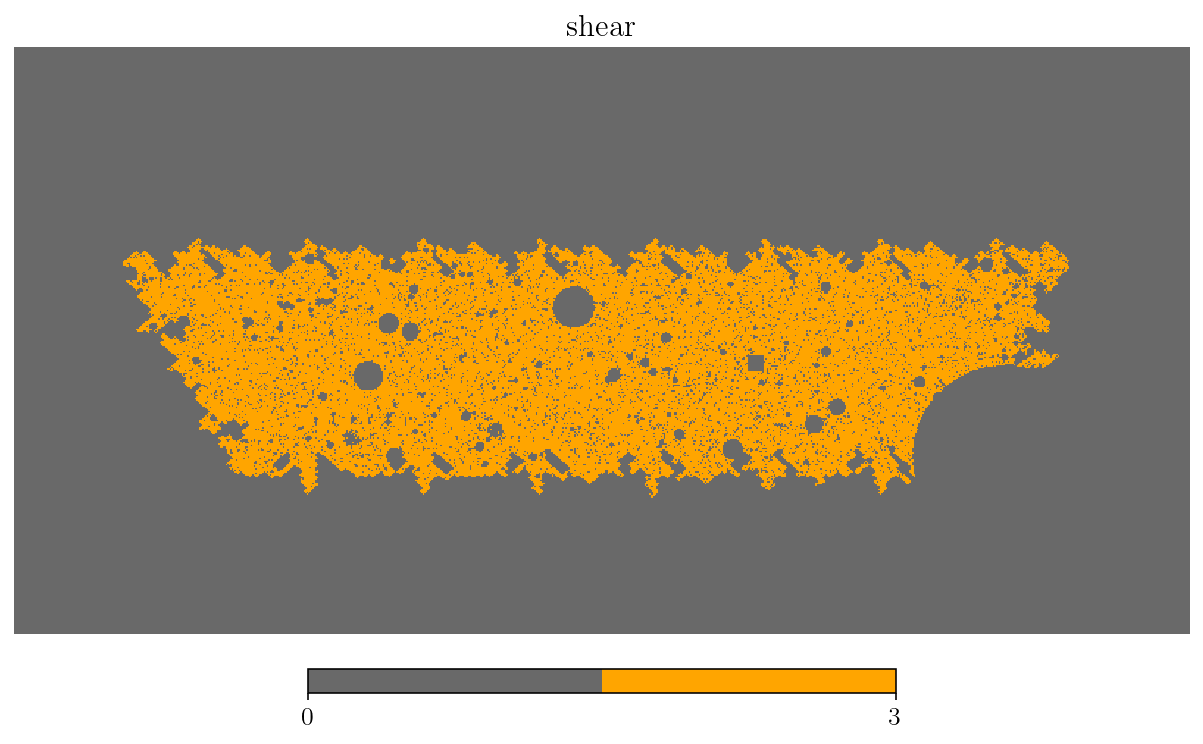

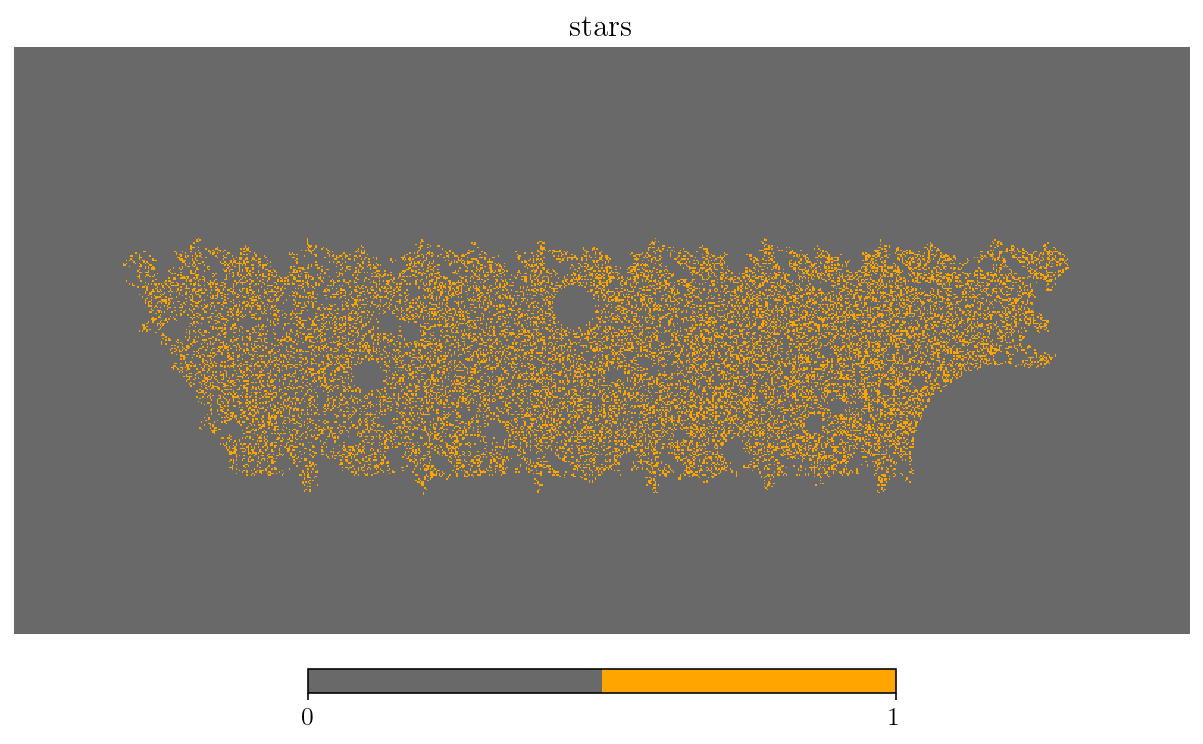

In [24]:
import healpy as hp

cmap = matplotlib.colors.ListedColormap(['dimgray', 'orange'])

# galaxies
tht,phi = rd2tp(gra, gdec)
gpix    = hp.ang2pix(8192,tht,phi)
gc      = np.bincount(gpix,minlength=hp.nside2npix(8192))

#stars
tht,phi = rd2tp(dd['u']['ra'], dd['u']['dec'])
spix    = hp.ang2pix(8192,tht,phi)
sc      = np.bincount(spix,minlength=hp.nside2npix(8192))

gc[gc>0]=3
sc[sc>0]=1

hp.azeqview(gc,rot=(-24,1),reso=1,xsize=800,ysize=400,title='galaxies',cmap=cmap)
hp.azeqview(sc,rot=(-24,1),reso=1,xsize=800,ysize=400,title='stars',cmap=cmap)


# Check shear 2pt 

In [57]:
import h5py 
import numpy as np
import treecorr 
def corrs(Xra,Xdec,Xg1,Xg2,Xw, Yra,Ydec,Yg1,Yg2,Yw,xtype):
    if xtype=='xip':
        thtmin,thtmax = 7,56
    if xtype=='xim': 
        thtmin,thtmax = 28,178    
    
    corr = treecorr.GGCorrelation(min_sep       = thtmin,
                                  max_sep       = thtmax,
                                  nbins         = 9,
                                  bin_slop      = 0.00,
                                  sep_units     = "arcmin",
                                  var_method    = "jackknife")
    
    cat1 = treecorr.Catalog(ra=Xra, dec=Xdec, g1=Xg1, g2=Xg2 ,w=Xw, ra_units="deg", dec_units="deg", npatch=150)
    cat2 = treecorr.Catalog(ra=Yra, dec=Ydec, g1=Yg1, g2=Yg2 ,w=Yw, ra_units="deg", dec_units="deg", patch_centers=cat1.patch_centers)

    corr.process(cat1, cat2)
    if xtype=='xip':
        return np.exp(corr.meanlogr), corr.xip
    if xtype=='xim':
        return np.exp(corr.meanlogr), corr.xim
    

# Compute shear (only the auto)
xip = {}

for i in range(0,4):   
    print("%d-%d"%(i,i))
    d = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/'
    x = np.load(d+'binned_shear_catalog_allfields_zbin%d.npz'%(i+1))
    gra,gdec,g1,g2,gw = x['ra'],x['dec'],x['g1'],x['g2'],x['gw']
    
    tht,xip = corrs(gra, gdec, g1, g2, gw, gra, gdec, g1, g2, gw, 'xip');
    ret['GG%d%d+'%(i+1,i+1)] = {'tht':tht,'xip':xip}
    tht,xim = corrs(gra, gdec, g1, g2, gw, gra, gdec, g1, g2, gw, 'xim');
    ret['GG%d%d-'%(i+1,i+1)] = {'tht':tht,'xim':xim}

0-0
1-1
2-2
3-3


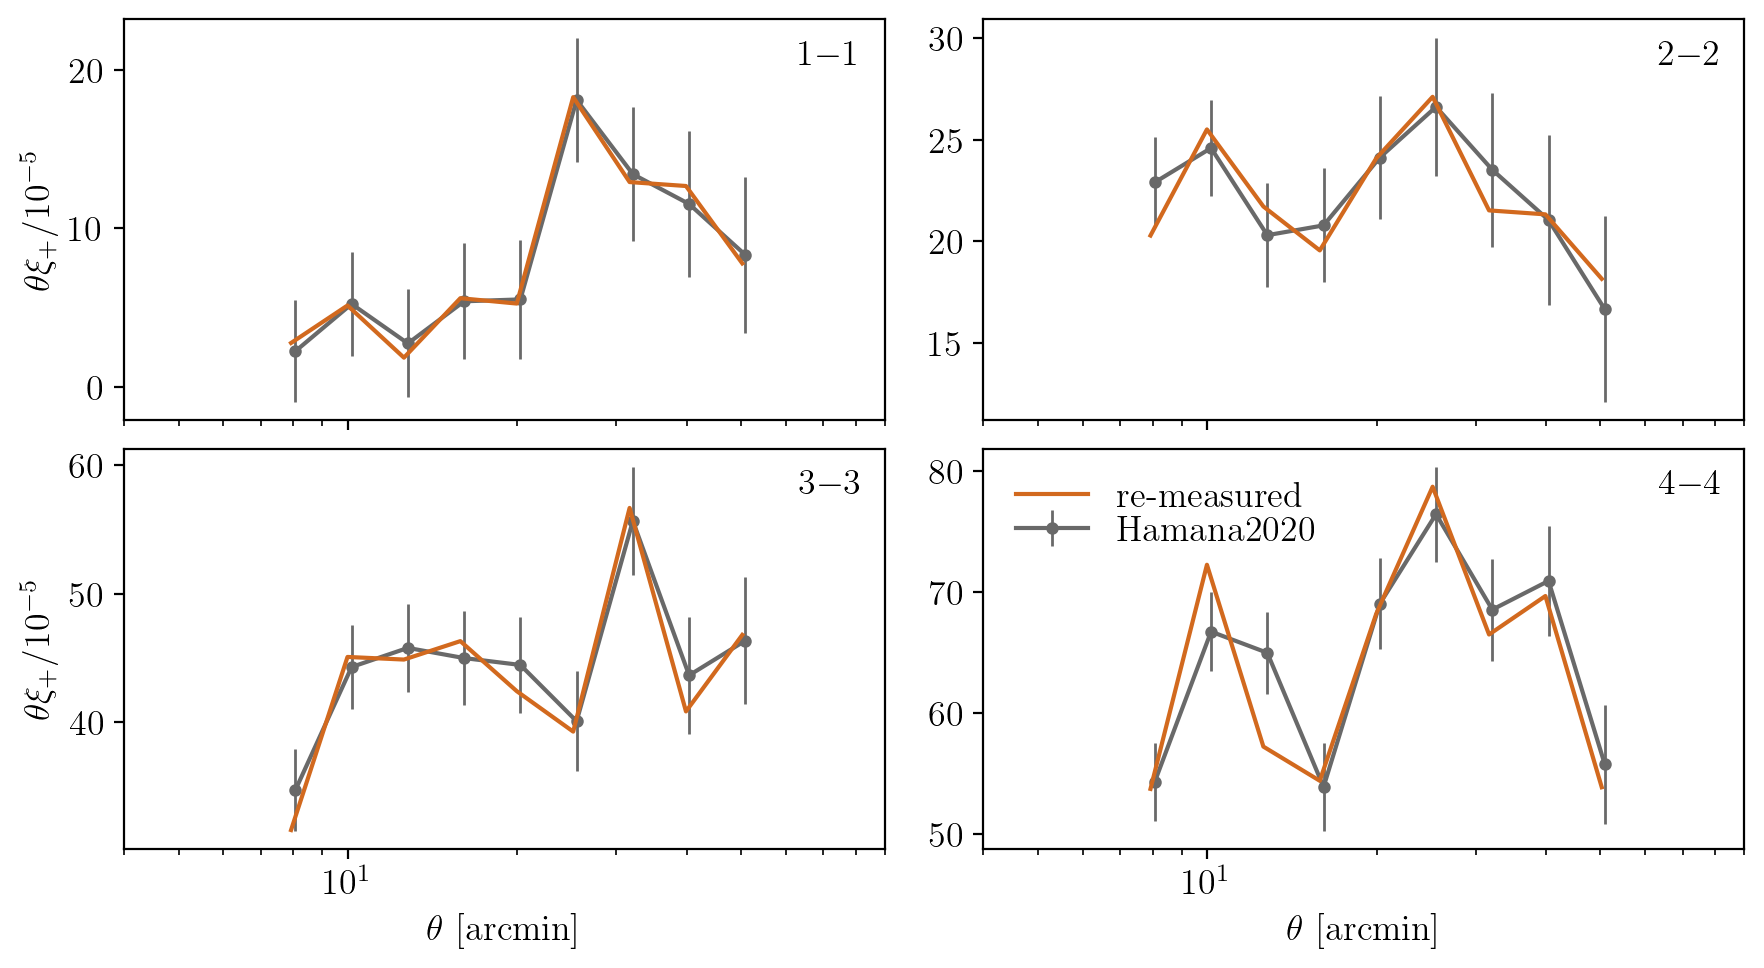

In [63]:

# Hamana official data vector
oxip = np.loadtxt('/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/hsc16a_cstpcf_h2020.xip')
ocov = np.loadtxt('/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hsc2txpipe/hsc16a_cstpcf_h2020.cov')
ocov = ocov.reshape((170,170))

_ = plt.figure(figsize=(10,5),dpi=100)
gs  = gridspec.GridSpec(2, 2,
                       top=0.98,
                       hspace=0.07,
                       wspace=0.13,
                       right=0.96,
                       left=0.15,
                       bottom=0.15
    
                       )
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

ax0.errorbar(oxip[:,0],oxip[:,0]*oxip[:,1]/1e-5,yerr=oxip[:,0]/1e-5*np.diag(ocov[:9,:9])**0.5,color='dimgray',label='Hamana2020',marker='o',elinewidth=1.,ms=3.5)
ax0.semilogx(ret['GG11+']['tht'],ret['GG11+']['tht']*ret['GG11+']['xip']/1e-5,color='chocolate',label='re-measured',zorder=1000)
#ax0.set_xlabel(r"$\theta\ [{\rm arcmin}]$")
ax0.set_ylabel(r"$\theta\xi_{+}/10^{-5}$")
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.text(0.97,0.95,r"$1{\mathrm -}1$",size=13,transform=ax0.transAxes,ha='right',va='top')
ax0.set_xlim(4,90)

ax1.errorbar(oxip[:,0],oxip[:,0]*oxip[:,5]/1e-5,yerr=oxip[:,0]/1e-5*np.diag(ocov[36:45,36:45])**0.5,color='dimgray',label='Hamana2020',marker='o',elinewidth=1.,ms=3.5)
ax1.semilogx(ret['GG22+']['tht'],ret['GG22+']['tht']*ret['GG22+']['xip']/1e-5,color='chocolate',label='re-measured',zorder=1000)
#ax1.set_xlabel(r"$\theta\ [{\rm arcmin}]$")
#ax1.set_ylabel(r"$\theta\xi^{+}/10^{-5}$")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.text(0.97,0.95,r"$2{\mathrm -}2$",size=13,transform=ax1.transAxes,ha='right',va='top')
ax1.set_xlim(4,90)

ax2.errorbar(oxip[:,0],oxip[:,0]*oxip[:,8]/1e-5,yerr=oxip[:,0]/1e-5*np.diag(ocov[:9,:9])**0.5,color='dimgray',label='Hamana2020',marker='o',elinewidth=1.,ms=3.5)
ax2.semilogx(ret['GG33+']['tht'],ret['GG33+']['tht']*ret['GG33+']['xip']/1e-5,color='chocolate',label='re-measured',zorder=1000)
ax2.set_xlabel(r"$\theta\ [{\rm arcmin}]$")
ax2.set_ylabel(r"$\theta\xi_{+}/10^{-5}$")
ax2.text(0.97,0.95,r"$3{\mathrm -}3$",size=13,transform=ax2.transAxes,ha='right',va='top')
ax2.set_xlim(4,90)

ax3.errorbar(oxip[:,0],oxip[:,0]*oxip[:,10]/1e-5,yerr=oxip[:,0]/1e-5*np.diag(ocov[:9,:9])**0.5,color='dimgray',label='Hamana2020',marker='o',elinewidth=1.,ms=3.5)
ax3.semilogx(ret['GG44+']['tht'],ret['GG44+']['tht']*ret['GG44+']['xip']/1e-5,color='chocolate',label='re-measured',zorder=1000)
ax3.set_xlabel(r"$\theta\ [{\rm arcmin}]$")
#ax3.set_ylabel(r"$\theta\xi^{+}/10^{-5}$")
ax3.text(0.97,0.95,r"$4{\mathrm -}4$",size=13,transform=ax3.transAxes,ha='right',va='top')
ax3.set_xlim(4,90)

plt.legend(frameon=False,labelspacing=0.05,loc='upper left',fontsize=13)

# Compute Tau0 (GP) and Tau2 (GQ) 

In [66]:
import treecorr 
def corrstau(Xra,Xdec,Xg1,Xg2,Xw, Yra,Ydec,Yg1,Yg2,Yw):
    corr = treecorr.GGCorrelation(min_sep       = 2,
                                  max_sep       = 150,
                                  nbins         = 16,
                                  bin_slop      = 0.00,
                                  sep_units     = "arcmin",
                                  var_method    = "jackknife")
    
    cat1 = treecorr.Catalog(ra=Xra, dec=Xdec, g1=Xg1, g2=Xg2 ,w=Xw, ra_units="deg", dec_units="deg", npatch=150)
    cat2 = treecorr.Catalog(ra=Yra, dec=Ydec, g1=Yg1, g2=Yg2 ,w=Yw, ra_units="deg", dec_units="deg", patch_centers=cat1.patch_centers)

    corr.process(cat1, cat2)
    return np.exp(corr.meanlogr), corr.xip, corr.xim


# Note: in Gatti or Mandelbaum q is defined as e_star-e_model
# But Hamana defines it as e_model-e_star
# 𝒑 ≡ emodel, 𝒒 ≡ 𝒆∗ − 𝒆model, and 𝒘 ≡ 𝒆* (𝑇∗ − 𝑇model) /𝑇*, an
# tau0 shear-p
# tau2 shear-q
# tau5 shear w

stype='r'
rsra  = dd[stype]['ra']
rsdec = dd[stype]['dec']
rp1   = dd[stype]['e1_model']
rp2   = dd[stype]['e2_model']
rq1   = dd[stype]['e1_model']-dd[stype]['e1_meas']
rq2   = dd[stype]['e2_model']-dd[stype]['e2_meas']

stype='u'
usra  = dd[stype]['ra']
usdec = dd[stype]['dec']
up1   = dd[stype]['e1_model']
up2   = dd[stype]['e2_model']
uq1   = dd[stype]['e1_model']-dd[stype]['e1_meas']
uq2   = dd[stype]['e2_model']-dd[stype]['e2_meas']


# Choose to use reserved star ("r") or used star ("u") or all ('all')
# Hamana uses reserved stars
use = 'r' 

if use=='all':
    sra  = np.concatenate([rsra,usra])
    sdec = np.concatenate([rsdec,usdec])
    p1   = np.concatenate([rp1,up1])
    p2   = np.concatenate([rp2,up2])
    q1   = np.concatenate([rq1,uq1])
    q2   = np.concatenate([rq2,uq2])
    
elif use=='r':
    sra,sdec,p1,p2,q1,q2 = rsra,rsdec,rp1,rp2,rq1,rq2 
    
elif use=='u':
    sra,sdec,p1,p2,q1,q2 = usra,usdec,up1,up2,uq1,uq2 
    
ret = {}
tht,xip,xim = corrstau(allgra, allgdec, allg1, allg2, allgw, sra, sdec, p1, p2, np.ones_like(sra)); ret['GP']={'tht':tht,'xip':xip,'xim':xim} #GP
tht,xip,xim = corrstau(allgra, allgdec, allg1, allg2, allgw, sra, sdec, q1, q2, np.ones_like(sra)); ret['GQ']={'tht':tht,'xip':xip,'xim':xim} #GP
#tht,xip,xim = corrs(gra, gdec, g1, g2, w, sra, sdec, e_psf[0]*de_psf[0],  e_psf[1]*de_psf[1], np.ones_like(sra)); ret['GW']={'tht':tht,'xip':xip} #GP



(-5e-06, 2.5e-05)

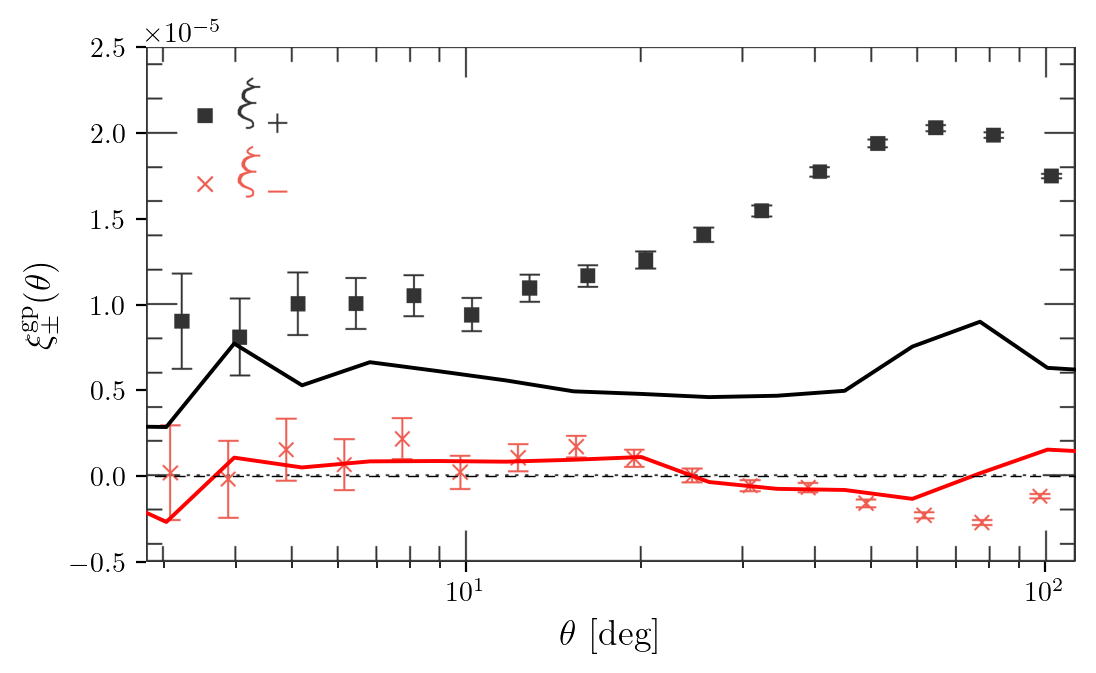

In [81]:
%matplotlib inline
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5),dpi=100)
img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hamana_gp.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim(2.8,113)
newax.set_ylim((-0.5e-5,2.5e-5))
newax.set_xlabel(r'$\theta\ [{\rm deg}]$',size=13)
newax.set_ylabel(r'$\xi_{\pm}^{\rm gp}(\theta)$',size=13)
newax.set_xscale('log')
#newax.set_yscale('symlog',linthresh=1e-6)
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().minorticks_off()

#plt.plot(ret['GP']['tht'],ret['GP']['xip'])
#plt.plot(ret['GQ']['tht'],ret['GQ']['xip'])
plt.plot(ret['GP']['tht'],ret['GP']['xip'],color='k',lw=1.4)
plt.plot(ret['GP']['tht'],ret['GP']['xim'],color='r',lw=1.4)

plt.semilogx(np.arange(201),np.zeros(201),'k--',dashes=(8,6),lw=0.5)
plt.semilogx()
plt.ylim(-0.5e-5,2.5e-5)


(-2.4e-06, 1.2e-06)

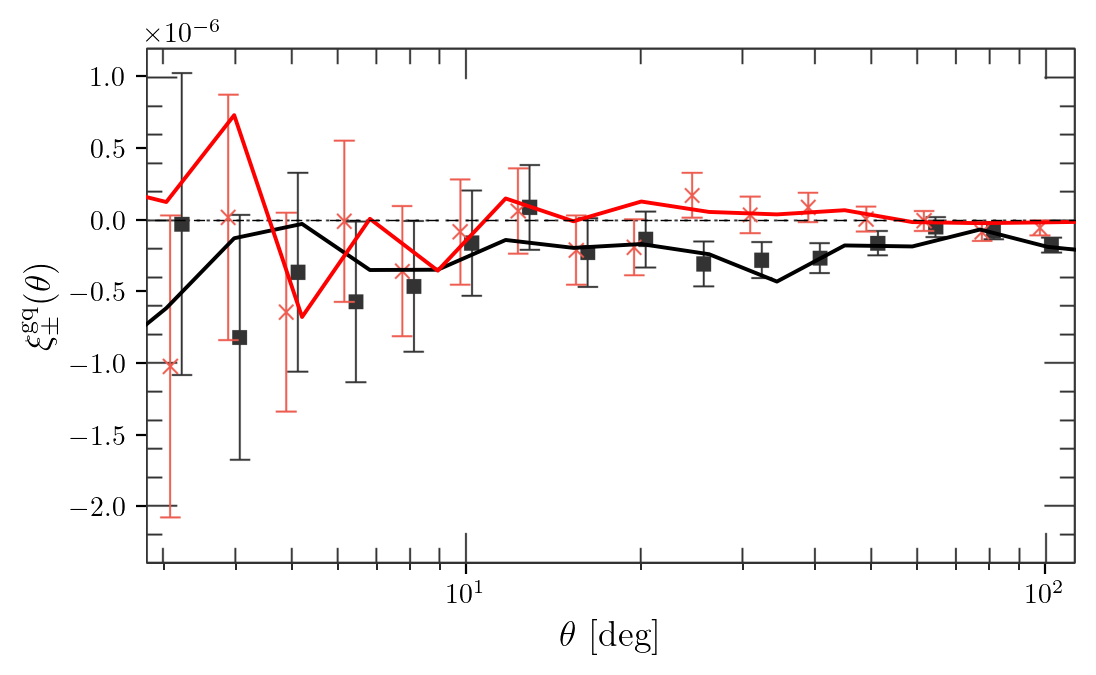

In [80]:
%matplotlib inline
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(6,4.5),dpi=100)
img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/scratch/HSC/hamana_gq.png")

#set first axes
ax = fig.add_subplot(1,1,1)
ax.imshow(img,  aspect='equal',alpha=0.8)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=False)
newax.set_xlim(2.8,113)
newax.set_ylim(-2.4e-6,1.2e-6)
newax.set_xlabel(r'$\theta\ [{\rm deg}]$',size=13)
newax.set_ylabel(r'$\xi_{\pm}^{\rm gq}(\theta) $',size=13)
newax.set_xscale('log')
#newax.set_yscale('symlog',linthresh=1e-6)
#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().minorticks_off()


plt.plot(ret['GQ']['tht'],ret['GQ']['xip'],color='k',lw=1.4)
plt.plot(ret['GQ']['tht'],ret['GQ']['xim'],color='r',lw=1.4)


plt.semilogx(np.arange(201),np.zeros(201),'k--',dashes=(8,6),lw=0.5)
plt.ylim(-2.4e-6,1.2e-6)